In [15]:
# in colab, please run:
!pip install transformers sentence-transformers datasets rouge_score nltk rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### [In-class version] Summarization

This notebook will guide you through the basics of test summarization within a nlp_cource seminar.

Later this day, the notebook will be replaced by a longer "homework" version.

In [2]:
import nltk
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import datasets
data = datasets.load_dataset("multi_news")
train_dataset, val_dataset = data['train'], data['validation']

SEMINAR_MODE = True

if SEMINAR_MODE:
    val_dataset = [val_dataset[i] for i in range(0, len(val_dataset), 5)]

Generating train split:   0%|          | 0/44972 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5622 [00:00<?, ? examples/s]

Dataset multi_news downloaded and prepared to /root/.cache/huggingface/datasets/multi_news/default/1.0.0/2f1f69a2bedc8ad1c5d8ae5148e4755ee7095f465c1c01ae8f85454342065a72. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
example = val_dataset[42]
sources = tuple(filter(len, map(str.strip, example['document'].split('|||||'))))

for i, source in enumerate(sources):
    print(f"SOURCE #{i}: {source}\n{'=' * 50}\n")
print("SUMMARY:\n", example['summary'])

SOURCE #0: (KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. 
 
 Police identified the suspect as Larson James RonDeau, 36. 
 
 According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. 
 
 Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes. 
 
 When the mother returned, her daughter's dress was "pulled up past her waist" and she "appeared to be upset", according to the statement. The mother said she then called for a cab and returned with her daughter to their own apartment. 
 
 When questioned by her mother, police say the girl told her "four meneach raped her." The PC statement describes in greater detail the alleged attack. One man, according to police, threatened to kill the li

In [5]:
MAX_WORDS = 100

def summarize_baseline(doc: str, max_words=MAX_WORDS):
    sentences = nltk.sent_tokenize('\n'.join(doc.split('|||||')))
    summary = []
    num_words = 0
    
    for sent in sentences:
        sentence_length = len(nltk.word_tokenize(sent))
        if num_words + sentence_length > max_words:
            break
        num_words += sentence_length
        summary.append(sent)
    return ' '.join(summary)

In [11]:
print(summarize_baseline(val_dataset[42]['summary']))

– "I want justice." That's what a woman is seeking for her 9-year-old granddaughter, who allegedly endured a brutal Easter Sunday attack by four men while her mom got high on meth in a friend's garage, KTSU reports. The men are accused of raping, sodomizing, and threatening the girl, who was with her mom in Vernal, Utah, visiting the home of a friend the mother reportedly met while in jail, per a probable cause statement cited in another KTSU report.


In [13]:
from rouge_score import rouge_scorer
from tqdm.auto import trange


scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score(target='The quick brown fox jumps over the lazy dog',
                      prediction='The quick brown dog jumps on the log.')
print(scores['rouge1'].fmeasure, scores['rougeL'].fmeasure)

0.7058823529411765 0.5882352941176471


In [29]:
def compute_rouge_f1(dataset, predictions):
    r1_scores = []
    rL_scores = []
    for i in range(len(dataset)):
        scores = scorer.score(target=dataset[i]['summary'], prediction=predictions[i])
        r1_scores.append(scores['rouge1'].fmeasure)
        rL_scores.append(scores['rougeL'].fmeasure)
    mean_r1 = sum(r1_scores) / len(r1_scores)
    mean_rL = sum(rL_scores) / len(rL_scores)
    return mean_r1, mean_rL

In [30]:
baseline_predictions = [summarize_baseline(row['document']) for row in val_dataset]
baseline_rouge1, baseline_rougeL = compute_rouge_f1(val_dataset, baseline_predictions)

print("Rouge-1:", baseline_rouge1)
print("Rouge-L:", baseline_rougeL)

if SEMINAR_MODE:
    assert abs(baseline_rouge1 - 0.26632) < 1e-3 and abs(baseline_rougeL - 0.14617) < 1e-3
    print("Well done!")

Rouge-1: 0.2668067854981659
Rouge-L: 0.1465153793717691
Well done!


### Neural extractive summarization

![](https://i.imgur.com/kkrzeq7.png)

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=True, max_features=50_000)
vectorizer.fit([item['document'] for item in train_dataset])
encode_func = lambda texts: vectorizer.transform(texts).toarray()

In [105]:
doc = val_dataset[42]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

Sentence embeddings shape: (72, 50000)
Document embedding shape: (4, 50000)


In [106]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarities between each pair of sentences
sentence_similarities = cosine_similarity(sentence_embeddings)

# ... and also between each sentence and each document
document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)

assert sentence_similarities.shape == (len(sentences), len(sentences))
assert document_similarities.shape == (len(sentences), len(documents))

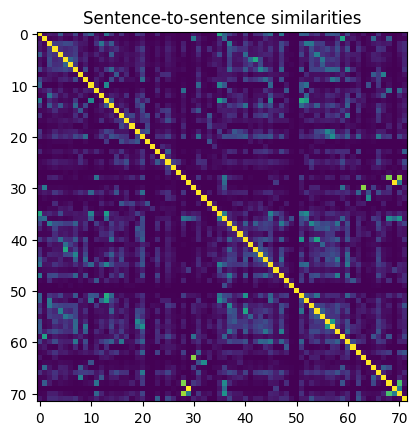

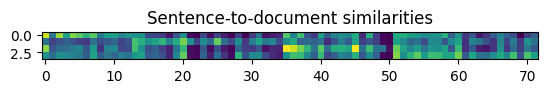

In [107]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()

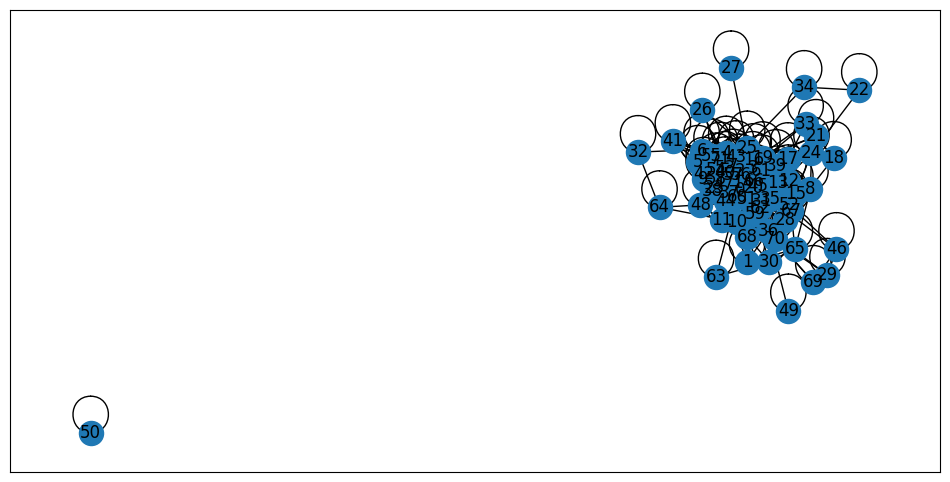

In [108]:
import networkx

plt.figure(figsize=(12, 6))
networkx.draw_networkx(networkx.from_numpy_array(sentence_similarities > 0.1))

In [109]:
def choose_summary_greedy(sentences, sentence_scores, sentence_similarities, sentence_lengths,
                          max_words=MAX_WORDS, sim_threshold=0.9):
    assert sentence_scores.shape == (len(sentences),)
    chosen_sentences = []
    max_similarities = np.zeros(len(sentences))
    num_words = 0

    for i in range(len(sentences)):
        mask = (sentence_lengths <= (max_words - num_words)) & (max_similarities < sim_threshold)
        if not np.any(mask):
            break

        best_sentence_index = np.argmax(sentence_scores * mask)

        chosen_sentences.append(sentences[best_sentence_index])


        max_similarities = np.maximum(max_similarities, sentence_similarities[best_sentence_index])
        num_words += sentence_lengths[best_sentence_index]
    
    return chosen_sentences



In [110]:
sentence_scores = sentence_similarities.mean(axis=-1)

summary_sentences = choose_summary_greedy(
    sentences, sentence_scores, sentence_similarities, sentence_lengths,
    max_words=MAX_WORDS, sim_threshold=0.7)
print(summary_sentences)

['One of the men allegedly told the girl he would kill her if she ever reported the incident, and the threat was made during the alleged rape.', "Related story: Grandmother of 9-year-old Utah girl allegedly raped by four men: ‘I want justice’ \n \n RonDeau told police that the other three men had traveled to Montana for personal business along with the woman who the girl's mother had been there to visit, Glynda RonDeau.", 'When questioned by her mother, police say the girl told her "four meneach raped her."']


### Putting it all together

In [111]:
def summarize_one(document, max_words=MAX_WORDS, sim_threshold=0.7):
    documents = tuple(filter(len, map(str.strip, document.split('|||||'))))

    sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
    sentences = [sent for document in sentences_by_doc for sent in document]
    sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

    if len(sentences) == 0:
      return ''
    
    # use encode_func to compute embedding matrices
    sentence_embeddings = encode_func(sentences)
    document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))

    sentence_similarities = cosine_similarity(sentence_embeddings)
    document_similarities = cosine_similarity(sentence_embeddings, document_embeddings)
    
    
    # Compute the scores s.t. higher score corresponds to better sentences.
    # There are many ways to devise such a function, try them for yourself and see which works best.
    # Here's a few inspirations:
    # - mean similarity to 3 nearest sentences [please start with this one]
    # - page-rank scores that use similarity matrix as connectivity matrix
    # - distance to the nearest cluster in embedding space using k-means clustering
    sentence_scores = sentence_similarities.mean(axis=-1)
    
    summary_sentences = choose_summary_greedy(
        sentences, sentence_scores, sentence_similarities, sentence_lengths,
        max_words=max_words, sim_threshold=sim_threshold)
    
    return '\n'.join(summary_sentences)

In [112]:
print(summarize_one(val_dataset[3]['document'], max_words=40))

With the iPhone 5 possibly on its way to Sprint Nextel, could the end of its much-loved unlimited-data plan be far behind?
But with the iPhone becoming available to Sprint customers, that timetable could be accelerated.


In [113]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [114]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.3169175388431203
Rouge-L: 0.16510283786055416


### Can we do better than TF-IDF?

In [66]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/LaBSE').train(False)

In [67]:
emb1, emb2, emb3, emb4 = model.encode(
    ['Hello, world!', 'Greeting, universe!', 'Hello, John!', "A cat sat on the mat."]
)

In [68]:
print("Sim(hello world, hello john) =", emb1 @ emb3)
print("Sim(hello world, greetings universe) =", emb1 @ emb2)
print("Sim(hello world, a cat sat on the mat)=", emb1 @ emb4)

Sim(hello world, hello john) = 0.7253736
Sim(hello world, greetings universe) = 0.7909732
Sim(hello world, a cat sat on the mat)= 0.1616299


In [69]:
encode_func = model.encode

Sentence embeddings shape: (32, 768)
Document embedding shape: (2, 768)


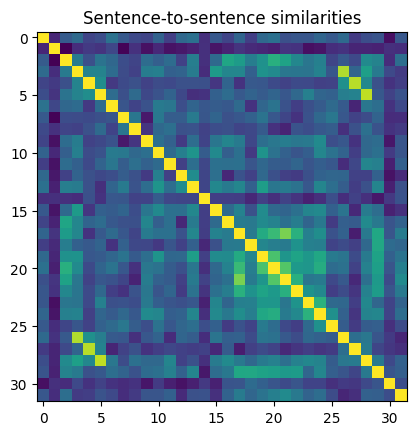

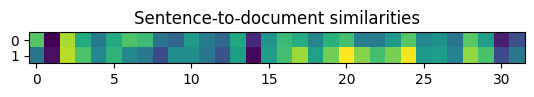

In [70]:
doc = val_dataset[50]
documents = tuple(filter(len, map(str.strip, doc['document'].split('|||||'))))

sentences_by_doc = [nltk.sent_tokenize(doc) for doc in documents]
sentences = [sent for document in sentences_by_doc for sent in document]
sentence_lengths = np.array([len(nltk.word_tokenize(sent)) for sent in sentences])

sentence_embeddings = encode_func(sentences)
document_embeddings = encode_func(list(map('\n'.join, sentences_by_doc)))
print("Sentence embeddings shape:", sentence_embeddings.shape)
print("Document embedding shape:", document_embeddings.shape)

sentence_similarities = sentence_embeddings @ sentence_embeddings.T
document_similarities = sentence_embeddings @ document_embeddings.T

plt.title("Sentence-to-sentence similarities")
plt.imshow(sentence_similarities)
plt.show()
plt.title("Sentence-to-document similarities")
plt.imshow(document_similarities.T)
plt.show()


In [71]:
our_summaries = []
for i in trange(len(val_dataset)):
    our_summaries.append(summarize_one(val_dataset[i]['document']))

  0%|          | 0/1125 [00:00<?, ?it/s]

In [72]:
our_rouge1, our_rougel = compute_rouge_f1(val_dataset, our_summaries)

print("Rouge-1:", our_rouge1)
print("Rouge-L:", our_rougel)

Rouge-1: 0.3067581883147516
Rouge-L: 0.1607688764764878


### Call the cavalry!

[Pegasus](https://arxiv.org/abs/1912.08777) is an *abstractive* summarization model based on a large pre-trained transformer. Before doing any summarizaton, the model is pre-trained on a combination of MLM and a specialized objective called Gap Sentence Generation: predicting an entire sentence omitted from the middle of the text.

In [97]:
import transformers
pegasus = transformers.pipeline("summarization", "google/pegasus-multi_news")

In [98]:
print(example['document'])

(KUTV) A Vernal man has been charged with raping a 9-year-old girl while police say the girl's mother was getting high on meth. 
 
 Police identified the suspect as Larson James RonDeau, 36. 
 
 According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. 
 
 Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes. 
 
 When the mother returned, her daughter's dress was "pulled up past her waist" and she "appeared to be upset", according to the statement. The mother said she then called for a cab and returned with her daughter to their own apartment. 
 
 When questioned by her mother, police say the girl told her "four meneach raped her." The PC statement describes in greater detail the alleged attack. One man, according to police, threatened to kill the little girl i

In [99]:
document = example['document'].split('|||||')[0]
print("SUMMARY:", pegasus([document], min_length=5, max_length=100)[0]['summary_text'])

SUMMARY: – A Vernal, Utah, man has been charged with raping a 9-year-old girl while her mother was high on meth, KUTV reports. According to a probable cause statement, the mother and daughter were spending Easter weekend with a friend the mother met while in jail. The mother said there were also four adult men staying at the home. Police said the mother and her friend agreed to get high on meth and went into the garage area, where they were for around 30 minutes
